In [121]:
import glob
from collections import Counter
import pandas as pd
import numpy as np
import scipy.special as sc
import keras
import tensorflow as tf
import chess
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout,Flatten

In [2]:
piece_to_index = dict([(piece, i) for i, piece in enumerate('pnbrqkPNBRQK')])

In [3]:
def board_bitmask_to_numpy(mask):
    mask = np.array([mask], dtype=np.uint64).view(np.uint8)
    return np.unpackbits(mask).reshape((8, 8))

In [19]:
df = pd.read_csv('evl_data.csv')
df.head()

,fen,scores,label_score
0,rnbqkbnr/pppppppp/8/8/5P2/8/PPPPP1PP/RNBQKBNR ...,-0.42,3.0
1,rnbqkbnr/pppp1ppp/8/4p3/5P2/8/PPPPP1PP/RNBQKBN...,0.84,3.0
2,rnbqkbnr/pppp1ppp/8/4P3/8/8/PPPPP1PP/RNBQKBNR ...,0.22,3.0
3,rnbqkbnr/ppp2ppp/3p4/4P3/8/8/PPPPP1PP/RNBQKBNR...,0.54,3.0
4,rnbqkbnr/ppp2ppp/3P4/8/8/8/PPPPP1PP/RNBQKBNR b...,0.32,3.0


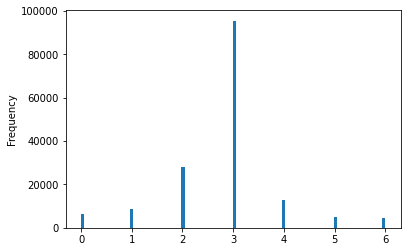

In [8]:
features = df.iloc[:,:-1]
response = df.iloc[:,-1].astype(float)

response.plot(kind='hist', bins=100)
plt.show()

In [16]:
class BasicRepresentation:
    """
    * requires (12, 8, 8) input size
    12 panes, one per type of piece
    2 more panes showing squares attacked by that side
    """
    def get_input_size(self):
        return (12, 8, 8)
    
    def from_fen(self, fen):
        result = np.zeros((12, 8, 8), dtype=np.int8)

        board = chess.Board(fen)

        is_flipped = False
        if board.turn == chess.BLACK:
            is_flipped = True
            board = board.mirror()

        for piece in range(1, 7): # chess numbers pieces from 1 to 6
            mask = board.pieces_mask(piece, chess.WHITE)
            result[piece-1, :, :] = board_bitmask_to_numpy(mask)[::-1, ::-1]
            mask = board.pieces_mask(piece, chess.BLACK)
            result[piece+5, :, :] = board_bitmask_to_numpy(mask)[::-1, ::-1]
        
        return result, is_flipped

In [17]:
class BasicRepresentationWithAttacked:
    """
    * requires (14, 8, 8) input size
    12 panes, one per type of piece
    2 more panes showing squares attacked by that side
    """
    def get_input_size(self):
        return (14, 8, 8)
    
    def from_fen(self, fen):
        result = np.zeros((14, 8, 8), dtype=np.int8)

        board = chess.Board(fen)

        is_flipped = False
        if board.turn == chess.BLACK:
            is_flipped = True
            board = board.mirror()

        for piece in range(1, 7): # chess numbers pieces from 1 to 6
            mask = board.pieces_mask(piece, chess.WHITE)
            result[piece-1, :, :] = board_bitmask_to_numpy(mask)[::-1, ::-1]
            mask = board.pieces_mask(piece, chess.BLACK)
            result[piece+5, :, :] = board_bitmask_to_numpy(mask)[::-1, ::-1]

        for i in range(8):
            for j in range(8):
                square = (7 - i) + j * 8
                result[12, j, i] = board.attackers_mask(chess.WHITE, square) > 0
                result[13, j, i] = board.attackers_mask(chess.BLACK, square) > 0
        
        return result, is_flipped

    
class CompactRepresentation:
    """
    * requires (6, 8, 8) input size
    7 panes, one per type of piece, +1 -> white, -1 -> black
    """
    def get_input_size(self):
        return (6, 8, 8)
    
    def from_fen(self, fen):
        result = np.zeros((6, 8, 8), dtype=np.int8)

        board = chess.Board(fen)

        is_flipped = False
        if board.turn == chess.BLACK:
            is_flipped = True
            board = board.mirror()

        for piece in range(1, 7): # chess numbers pieces from 1 to 6
            mask = board.pieces_mask(piece, chess.WHITE)
            result[piece-1, :, :] = board_bitmask_to_numpy(mask)[::-1, ::-1]
            mask = board.pieces_mask(piece, chess.BLACK)
            result[piece+5, :, :] = board_bitmask_to_numpy(mask)[::-1, ::-1]
        
        return result, is_flipped


In [285]:
class HalfKP:
    """
    * requires (10, 8, 8, 8, 8) input size
    10 panes, one per type of piece
    TODO: requires sparse inputs, a list of classes
    """
    def get_input_size(self):
        return (6, 8, 8)

    def from_fen(fen):
        pass

def create_simple_dense_model(representation):
    input_ = tf.keras.Input(shape=representation.get_input_size(), dtype='int8')
    flat = tf.keras.layers.Flatten()(input_)
    hidden1 = tf.keras.layers.Dense(1024, activation='elu',
                                    #kernel_regularizer=tf.keras.regularizers.L2(1e-9)
                                    )(flat)
    dropout1 = tf.keras.layers.Dropout(0.1)(hidden1)
    hidden2 = tf.keras.layers.Dense(512, activation='elu',
                                    #kernel_regularizer=tf.keras.regularizers.L2(1e-9)
                                    )(dropout1)
    hidden3 = tf.keras.layers.Dense(128, activation='elu',
                                    #kernel_regularizer=tf.keras.regularizers.L2(1e-9)
                                    )(hidden2)

    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(hidden3)
    model = tf.keras.Model(inputs=input_, outputs=outputs)
    loss = nn.CrossEntropyLoss()
    model.compile(optimizer="Adam",loss='mae')
    model.summary()
    return model


def create_conv_model(representation):
    input_ = tf.keras.Input(shape=representation.get_input_size(), dtype='float32')

    # permutation solves the problem of having the tensor we want to permute last
    # TODO: solve this problem in the representations.
    perm = tf.keras.layers.Permute((2, 3, 1))(input_)
    conv1 =  tf.keras.layers.Conv1D(filters = 16, kernel_size=(14), padding='same', activation='relu',
                             input_shape=(1, 8,8))(perm)
    # pooling =  tf.keras.layers.MaxPooling1D()(conv1)
    
    flat = tf.keras.layers.Flatten()(conv1)
    hidden1 = tf.keras.layers.Dense(1024, activation='elu',
                                    #kernel_regularizer=tf.keras.regularizers.L2(1e-9)
                                    )(flat)
    dropout1 = tf.keras.layers.Dropout(0.1)(hidden1)
    hidden2 = tf.keras.layers.Dense(512, activation='elu',
                                    #kernel_regularizer=tf.keras.regularizers.L2(1e-9)
                                    )(dropout1)
    hidden3 = tf.keras.layers.Dense(128, activation='elu',
                                    #kernel_regularizer=tf.keras.regularizers.L2(1e-9)
                                    )(hidden2)

    outputs = tf.keras.layers.Dense(7, activation='sigmoid')(hidden3)
    model = tf.keras.Model(inputs=input_, outputs=outputs)
    model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    model.summary()
    return model

In [286]:
from keras.utils.np_utils import to_categorical

In [291]:
#To do scaling the input 
def load_data(filename, representation):
    df = pd.read_csv(filename)

    sample = []
    ys = []
    for i, (fen, scores,label_score ) in df.iterrows():
        #if total <= 2:
        #    continue
        if i >= 2000:
            break

        input_layer, is_flipped = representation.from_fen(fen)
        sample.append(input_layer)

        ys.append([label_score])
        
            
    sample = np.array(sample, dtype=np.int8)
    ys = np.array(ys)
            
    return sample, ys

In [292]:
if __name__ == '__main__':
    representation = BasicRepresentationWithAttacked()
    # model = create_simple_dense_model(representation)
    model = create_conv_model(representation)
    sample, ys = load_data('evl_data.csv', representation)

    print(sample.shape, ys.shape)


Model: "model_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_44 (InputLayer)       [(None, 14, 8, 8)]        0         
                                                                 
 permute_42 (Permute)        (None, 8, 8, 14)          0         
                                                                 
 conv1d_42 (Conv1D)          (None, 8, 8, 16)          3152      
                                                                 
 flatten_40 (Flatten)        (None, 1024)              0         
                                                                 
 dense_182 (Dense)           (None, 1024)              1049600   
                                                                 
 dropout_43 (Dropout)        (None, 1024)              0         
                                                                 
 dense_183 (Dense)           (None, 512)               524

In [293]:
X_train, X_test, y_train, y_test = train_test_split(sample, ys, test_size=0.3)


In [294]:
save_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="C:/Users/congcong/Desktop/FYP/model/chess-score-{epoch:04d}-{val_loss:.4f}.h5",
    save_weights_only=False,
    save_best_only=True,
    verbose=1)

# Train the model with the new callback
history = model.fit(X_train, y_train,
                    validation_data = (X_test, y_test),
                    batch_size=32,
                    epochs=20,
                    callbacks=[save_callback])

Epoch 1/20


InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "c:\users\congcong\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\users\congcong\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\users\congcong\appdata\local\programs\python\python38\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "c:\users\congcong\appdata\local\programs\python\python38\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "c:\users\congcong\appdata\local\programs\python\python38\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "c:\users\congcong\appdata\local\programs\python\python38\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\users\congcong\appdata\local\programs\python\python38\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "c:\users\congcong\appdata\local\programs\python\python38\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "c:\users\congcong\appdata\local\programs\python\python38\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "c:\users\congcong\appdata\local\programs\python\python38\lib\site-packages\ipykernel\kernelbase.py", line 461, in dispatch_queue
      await self.process_one()
    File "c:\users\congcong\appdata\local\programs\python\python38\lib\site-packages\ipykernel\kernelbase.py", line 450, in process_one
      await dispatch(*args)
    File "c:\users\congcong\appdata\local\programs\python\python38\lib\site-packages\ipykernel\kernelbase.py", line 357, in dispatch_shell
      await result
    File "c:\users\congcong\appdata\local\programs\python\python38\lib\site-packages\ipykernel\kernelbase.py", line 652, in execute_request
      reply_content = await reply_content
    File "c:\users\congcong\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py", line 359, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "c:\users\congcong\appdata\local\programs\python\python38\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\users\congcong\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py", line 2768, in run_cell
      result = self._run_cell(
    File "c:\users\congcong\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py", line 2814, in _run_cell
      return runner(coro)
    File "c:\users\congcong\appdata\local\programs\python\python38\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\users\congcong\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py", line 3012, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\users\congcong\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py", line 3191, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\users\congcong\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py", line 3251, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\congcong\AppData\Local\Temp\ipykernel_16068\392288628.py", line 8, in <module>
      history = model.fit(X_train, y_train,
    File "c:\users\congcong\appdata\local\programs\python\python38\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\congcong\appdata\local\programs\python\python38\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\users\congcong\appdata\local\programs\python\python38\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "c:\users\congcong\appdata\local\programs\python\python38\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\users\congcong\appdata\local\programs\python\python38\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "c:\users\congcong\appdata\local\programs\python\python38\lib\site-packages\keras\engine\training.py", line 860, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\users\congcong\appdata\local\programs\python\python38\lib\site-packages\keras\engine\training.py", line 918, in compute_loss
      return self.compiled_loss(
    File "c:\users\congcong\appdata\local\programs\python\python38\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\users\congcong\appdata\local\programs\python\python38\lib\site-packages\keras\losses.py", line 141, in __call__
      losses = call_fn(y_true, y_pred)
    File "c:\users\congcong\appdata\local\programs\python\python38\lib\site-packages\keras\losses.py", line 245, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\users\congcong\appdata\local\programs\python\python38\lib\site-packages\keras\losses.py", line 1862, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "c:\users\congcong\appdata\local\programs\python\python38\lib\site-packages\keras\backend.py", line 5202, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
Received a label value of -5 which is outside the valid range of [0, 7).  Label values: -5 -3 4 -3 5 -5 -2 2 0 3 5 4 1 -3 3 -4 -2 -2 3 -3 3 4 0 3 3 2 6 -2 -2 -1 2 3
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_348894]

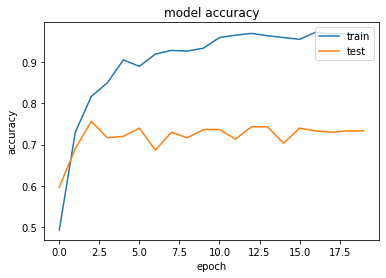

In [272]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [273]:
print(history)

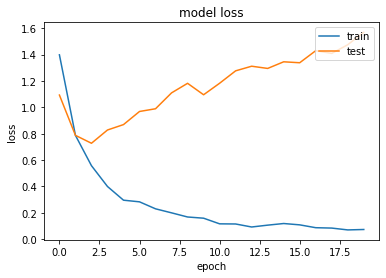

In [274]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')